In [1]:

# !pip install keras hyp3_sdk shapely openvino boto3 asf_search xarray rioxarray tensorflow
# protobuf==3.20.2
from glob import glob
from tqdm import tqdm
import zipfile
from datetime import datetime
from shapely.geometry import Point
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray
import numpy as np

from hyp3_sdk import HyP3
import asf_search as asf

import keras
from openvino.runtime import Core
import openvino.inference_engine as ie

from itertools import product
import boto3
import time

from hyp3_config import LOGIN, PASSWORD


2023-04-27 02:00:45.334259: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-27 02:00:45.334282: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Hyo3 usage: used 4.6%


In [2]:
"""
Notebook goal is :
    
    - Request a tile of Sentinel1 data from ASF
    - Download it locally 
    - Apply pre trained model to the tile to predict forest/non forest cover
    - Compile the model for optimized CPU use using OpenVINO
    - Apply to the same tile 
    - Apply the compiled model over the full iinput region 
    - Export the output prediction map to S3
"""

'\nNotebook goal is :\n    \n    - Request a tile of Sentinel1 data from ASF\n    - Download it locally \n    - Apply pre trained model to the tile to predict forest/non forest cover\n    - Compile the model for optimized CPU use using OpenVINO\n    - Apply to the same tile \n    - Apply the compiled model over the full iinput region \n    - Export the output prediction map to S3\n'

In [4]:
# Define granules start and end time
start_time = datetime.strptime("21 June, 2018", "%d %B, %Y")
end_time = datetime.now()
# Define coordinate around which to search °N , °E
coordinates = (16.7, 95.1)
print(f"Searching for granules between {start_time} and {end_time}")
results = asf.search(
    platform=asf.PLATFORM.SENTINEL1,
    polarization=asf.POLARIZATION.VV_VH,
    processingLevel=[asf.PRODUCT_TYPE.GRD_HD],
    start=int(datetime.timestamp(start_time)),
    end=int(datetime.timestamp(end_time)),
    beamSwath="IW",
    intersectsWith=Point(coordinates[1], coordinates[0]).wkt,
)
print(f"Found {len(results)} granules!")


Searching for granules between 2018-06-21 00:00:00 and 2023-04-27 02:00:58.029843


/home/ubuntu/miniconda3/envs/venv/lib/python3.8/site-packages/dateparser/utils/__init__.py:131: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = tz.localize(date_obj)


Found 647 granules!


In [ ]:
hyp3 = HyP3(username=LOGIN, password=PASSWORD)

for res in results[-1]:
    granule = res.properties["sceneName"]
    job = hyp3.submit_rtc_job(
        granule=granule,
        name="test",
        radiometry="sigma0",
        resolution=10,
        scale="decibel",
    )

successful_jobs = hyp3.find_jobs(status_code="SUCCEEDED")

import os
from pathlib import Path

for job in successful_jobs:
    granule = job.job_parameters["granules"][0]
    target_folder = "/home/ubuntu/documents/data/SENTINEL1_ASF/" + granule
    Path(target_folder).mkdir(parents=True, exist_ok=True)
    if len(os.listdir(target_folder)) == 0:
        job.download_files(target_folder)
        zipfiles = glob.glob(target_folder + "/*.zip")
        with zipfile.ZipFile(zipfiles[0], "r") as zip_ref:
            zip_ref.extractall("/home/ubuntu/documents/data/SENTINEL1_ASF/" + granule)



In [5]:
granule = "S1B_IW_GRDH_1SDV_20180814T095659_20180814T095728_012257_01695F_6883"
date_format_S1 = "%Y-%m-%dT%H:%M:%S.%fZ"

# reverse granule search
# we can use asf on the granule name to retrieve some parameters
results = asf.granule_search(granule)
res = results[1]
obs_time = datetime.strptime(res.properties["startTime"], date_format_S1)
print(f"Granule {granule} observation time {obs_time}")
# granule name is the fileID res.properties["fileID"].split("-")[0]

Granule S1B_IW_GRDH_1SDV_20180814T095659_20180814T095728_012257_01695F_6883 observation time 2018-08-14 09:56:59


Array to predict loaded !


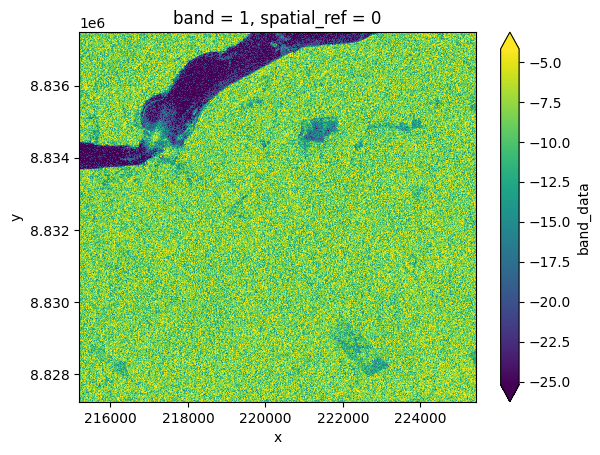

In [6]:
# A full sentinel 1 tile is 25Kx30k not manageable in memory
# we process it in chunks of 1024x1024
size = 1024


def load_subtile(granule, x0=15000, y0=12500, size=1024, display=False):
    if (
        len(
            glob(
                f"/home/ubuntu/documents/data/SENTINEL1_ASF/{granule}/**/*_VH.tif",
                recursive=True,
            )
        )
        == 0
    ):
        print(f"granule {granule} VH file not found!")
        return None
    try:
        s1_data_VH = xr.open_dataset(
            glob(
                f"/home/ubuntu/documents/data/SENTINEL1_ASF/{granule}/**/*_VH.tif",
                recursive=True,
            )[0]
        )
        s1_data_VV = xr.open_dataset(
            glob(
                f"/home/ubuntu/documents/data/SENTINEL1_ASF/{granule}/**/*_VV.tif",
                recursive=True,
            )[0]
        )

        if display:
            s1_data_VV.band_data[0, x0 : x0 + size, y0 : y0 + size].plot(robust=True)
        # model requires a 3 channel input
        img = np.stack(
            [
                s1_data_VV.band_data[0, x0 : x0 + size, y0 : y0 + size],
                s1_data_VH.band_data[0, x0 : x0 + size, y0 : y0 + size],
                s1_data_VH.band_data[0, x0 : x0 + size, y0 : y0 + size],
            ]
        )
        original_size = img.shape
        img = np.pad(
            img, ((0, 0), (0, size - img.shape[1]), (0, size - img.shape[2])), "reflect"
        )

        # normalize range of values
        data = 5 * (np.maximum(-49, np.minimum(1, img)) + 50)
        # fill with the mean value per band:
        col_mean = np.nanmean(data, axis=(1, 2))
        filled_data = np.array(data)
        for i in range(3):
            filled_data[i] = np.where(np.isnan(data[i]), col_mean[i], data[i])
        # reshape for prediction
        to_predict = np.moveaxis(filled_data, 0, 2).reshape((1, size, size, 3)) / 255
        return to_predict, original_size
    except:
        return None, None


to_predict, _ = load_subtile(granule, display=True)
print("Array to predict loaded !")


The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


2023-04-27 02:01:23.348828: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-27 02:01:23.348848: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-27 02:01:23.348865: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-60-56): /proc/driver/nvidia/version does not exist
2023-04-27 02:01:23.403199: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-27 02:01:23.605966: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 377

1.40s. loading model
1/1 [==============================] - 6s 6s/step
5.71s predicting and displaying single tile output


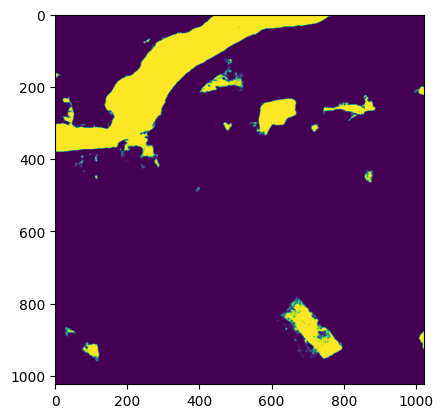

In [7]:
start = time.time()
model = keras.models.load_model(
    "/home/ubuntu/documents/model_sentinel1_deforestion_3nd_sample.h5", compile=False
)
end = time.time()
print(f"{end - start:.2f}s. loading model")
# perform prediction
start = time.time()
prediction = model.predict(to_predict)
# plot prediction
plt.imshow(prediction.squeeze())
end = time.time()
print(f"{end - start:.2f}s predicting and displaying single tile output")
keras_prediction_time = end - start

Command used to make a the OpenVino model
mo --saved_model_dir "/home/ubuntu/documents/sentinel1_model" --input_shape "[1,1024,1024,3]" --model_name "sentinel1_forest_cover" --compress_to_fp16 -nthreads NUM_THREADS --output_dir "/home/ubuntu/documents/sentinel1_openvino"
0.82s. loading model
2.73s. OpenVino prediction time.


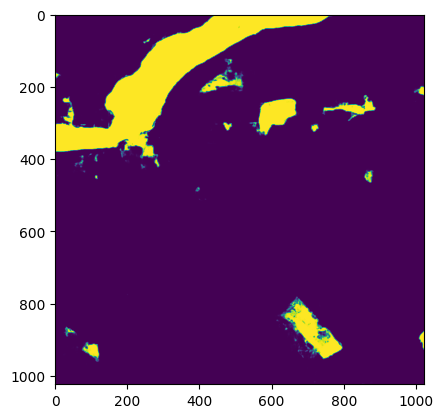

In [8]:
"""
Using a compiled models and optimization for CPU the inference time can be reduced.
We also reduce computation precision."""

mo_command = f"""mo
                 --saved_model_dir "/home/ubuntu/documents/sentinel1_model"
                 --input_shape "[1,1024,1024,3]"
                 --model_name "sentinel1_forest_cover"
                 --compress_to_fp16
                 -nthreads NUM_THREADS
                 --output_dir "/home/ubuntu/documents/sentinel1_openvino"
                 """
print("Command used to make a the OpenVino model")
print(" ".join(mo_command.split()))


start = time.time()
ie = Core()
ie.set_property("CPU", {"INFERENCE_NUM_THREADS": 16})
model_vino = ie.read_model(
    "/home/ubuntu/documents/sentinel1_openvino/sentinel1_forest_cover.xml"
)
compiled_model = ie.compile_model(model=model_vino, device_name="CPU")
end = time.time()
print(f"{end - start:.2f}s. loading model")
start = time.time()
input_key = compiled_model.input(0)
output_key = compiled_model.output(0)
network_input_shape = input_key.shape
# perform prediction
prediction_vino = compiled_model(to_predict)[output_key]
plt.imshow(prediction_vino.squeeze())
end = time.time()
print(f"{end - start:.2f}s. OpenVino prediction time.")
openvino_prediction_time = end - start



Not equal to tolerance rtol=0.001, atol=1e-05

Mismatched elements: 84228 / 1048576 (8.03%)
Max absolute difference: 0.1534375
Max relative difference: 4.671914
 x: array([[2.507827e-03, 9.176107e-04, 3.006015e-04, ..., 8.334157e-05,
        1.995462e-04, 5.206192e-04],
       [3.638814e-04, 1.838235e-04, 1.018706e-04, ..., 5.434427e-05,...
 y: array([[2.531052e-03, 9.217262e-04, 3.025532e-04, ..., 8.052588e-05,
        1.927614e-04, 5.083084e-04],
       [3.719330e-04, 1.869202e-04, 1.034141e-04, ..., 5.286932e-05,...


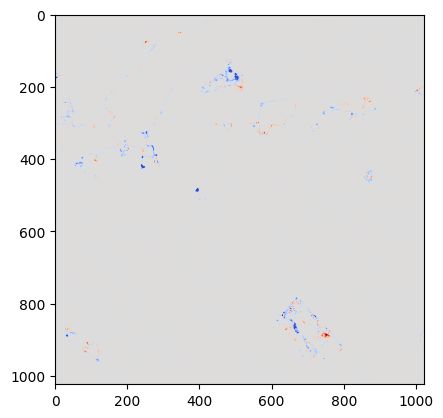

Compiled model 47.83% faster


In [9]:
try:
    np.testing.assert_allclose(
        prediction_vino.squeeze(), prediction.squeeze(), rtol=1e-03, atol=1e-05
    )
    print("Exported model has been tested and the differences are within the theshold!")
except AssertionError as e:
    print(e)
    plt.imshow(
        (prediction - prediction_vino).squeeze(), cmap="coolwarm", vmin=-0.05, vmax=0.05
    )
    plt.show()

print(
    f"Compiled model {openvino_prediction_time/keras_prediction_time*100:.2f}% faster"
)


In [ ]:
print("Running prediciton for a whole tile")
prediction_full = xr.open_dataset(
    glob(
        f"/home/ubuntu/documents/data/SENTINEL1_ASF/{granule}/**/*_VH.tif",
        recursive=True,
    )[0]
).copy(deep=True)
mask_data = xr.where(np.isnan(prediction_full), True, False).astype("bool")
# prediction_full.band_data[0,15000:15000+size, 12500:12500+size] = prediction_vino.squeeze()
for ix, iy in tqdm(
    product(
        range(len(prediction_full.x) // size), range(len(prediction_full.y) // size)
    ),
    total=len(prediction_full.x) // size * len(prediction_full.y) // size,
):
    x0 = ix * size
    y0 = iy * size
    to_predict, original_size = load_subtile(granule, x0, y0)
    if to_predict is None:
        prediction = np.full_like(to_predict[0, ..., -1], np.nan)
        original_size = (1, 1024, 1024)
    elif np.all(np.isnan(to_predict)):
        prediction = np.full_like(to_predict[0, ..., -1], np.nan)
        original_size = (1, 1024, 1024)
    else:
        prediction = compiled_model(to_predict)[output_key].squeeze()
    prediction_full.band_data[0, x0 : x0 + size, y0 : y0 + size] = prediction[
        : original_size[1], : original_size[2]
    ]

print("Approximately 25 min to run the prediction.")
prediction_full = prediction_full.where(mask_data, np.nan)
prediction_full.band_data[0, ::100, ::100].hvplot(rasterize=True, width=400)

# binarize output map
prediction_full = prediction_full > 0.5


# Save locally
saved_file = (
    f"/home/ubuntu/documents/data/SENTINEL1_ASF/{granule}/{granule}_prediction_v1.tif"
)
prediction_full.band_data.rio.to_raster(
    saved_file,  # need to update with the model version
    compress="lzw",
    num_threads="all_cpus",
    dtype="uint8",
    driver="COG",
    predictor=2,
    windowed=True,
)

# #%% Save to S3
session = boto3.Session(profile_name="saml-pub")
s3 = session.resource("s3")
s3.Bucket("esdswg-experiments").upload_file(
    saved_file, f"sentinel1_forest_cover/{granule}_prediction_v1.tif"
)




#### Notes:
- It might also be possible to upload a raster directly by creating a memory file first.
- Implement a better visualisation of the full tile predicted without crashing the memory with hvplot 
